In [2]:
import pandas as pd

earnings_call_train_df = pd.read_csv('data/earnings_call_train.csv')
stock_prices_train_df = pd.read_csv('data/stock_prices_train.csv')


transcripts_train_df = pd.read_csv('data/transcripts_train.csv')
transcripts_test_df = pd.read_csv('data/transcripts_test.csv')


print(earnings_call_train_df.head())

print(stock_prices_train_df.head())

print(transcripts_train_df.head())


# Convert 'date' columns to datetime objects
earnings_call_train_df["date"] = pd.to_datetime(earnings_call_train_df["date"])
stock_prices_train_df["date"] = pd.to_datetime(stock_prices_train_df["date"])
transcripts_train_df["date"] = pd.to_datetime(transcripts_train_df["date"])
transcripts_test_df["date"] = pd.to_datetime(transcripts_test_df["date"])




                                                text     label company  \
0  * Lisa Su    Advanced Micro Devices, Inc. - Pr...  positive     AMD   
1  * Matt Ramsay    Canaccord Genuity - Analyst  ...  positive     AMD   
2  ==============================================...  positive     AMD   
3   Ruth Cotter,  Advanced Micro Devices, Inc. - ...  positive     AMD   
4   Lisa Su,  Advanced Micro Devices, Inc. - Pres...  positive     AMD   

         date  para_no  
0  2016-07-21        4  
1  2016-07-21        6  
2  2016-07-21        7  
3  2016-07-21        8  
4  2016-07-21        9  
         date    open    high     low   close  adj_close   volume company
0  2016-01-04  656.29  657.72  627.51  636.99     636.99  9314500    AMZN
1  2016-01-05  646.86  646.91  627.65  633.79     633.79  5822600    AMZN
2  2016-01-06  622.00  639.79  620.31  632.65     632.65  5329200    AMZN
3  2016-01-07  621.80  630.00  605.21  607.94     607.94  7074900    AMZN
4  2016-01-08  619.66  624.14  606.

In [4]:

merged_df = pd.merge(transcripts_train_df, stock_prices_train_df, on=['company', 'date'], how='left')

merged_df = merged_df.sort_values(by=["company", "date"])

# Calculate close abnd returns
merged_df["next_day_close"] = merged_df.groupby("company")["close"].shift(-1)

merged_df["next_week_close"] = merged_df.groupby("company")["close"].shift(-5)

merged_df["next_day_return"] = (merged_df["next_day_close"] - merged_df["close"]) / merged_df["close"]
merged_df["next_week_return"] = (merged_df["next_week_close"] - merged_df["close"]) / merged_df["close"]

print(merged_df.head())

print(merged_df.isnull().sum())

    company       date                                         transcript  \
44     AAPL 2016-04-26  \n\nThomson Reuters StreetEvents Event Transcr...   
143    AAPL 2016-07-26  \n\nThomson Reuters StreetEvents Event Brief\n...   
3      AAPL 2016-10-25  \n\nThomson Reuters StreetEvents Event Brief\n...   
31     AAPL 2017-05-02  \n\nThomson Reuters StreetEvents Event Brief\n...   
8      AAPL 2017-08-01  \n\nThomson Reuters StreetEvents Event Brief\n...   

        open     high      low    close  adj_close     volume  next_day_close  \
44   25.9775  26.3250  25.9775  26.0875  24.342396  224064800         24.1675   
143  24.2050  24.4925  24.1050  24.1675  22.688135  224959200         29.5625   
3    29.4875  29.5900  29.3275  29.5625  27.903230  192516000         36.8775   
31   36.8850  37.0225  36.7100  36.8775  35.138050  181408800         37.5125   
8    37.2750  37.5550  37.1025  37.5125  35.890636  141474400         42.0275   

     next_week_close  next_day_return  next_week_r

In [6]:
# aggretate sentiment by combining data files

sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}
earnings_call_train_df["sentiment_score"] = earnings_call_train_df["label"].map(sentiment_mapping)

# Aggregate sentiment for each earnings call (company and date)
# We can take the mean of sentiment scores for all paragraphs in a call.
aggregated_sentiment = earnings_call_train_df.groupby(["company", "date"])["sentiment_score"].mean().reset_index()
aggregated_sentiment = aggregated_sentiment.rename(columns={"sentiment_score": "aggregated_sentiment_score"})

merged_df = pd.merge(merged_df, aggregated_sentiment, on=["company", "date"], how="left")

print("with Aggregated Sentiment Head:")
print(merged_df.head())

# Missing values
print(merged_df.isnull().sum())

# Analyze correlation between aggregated sentiment and stock price movements
correlation_next_day_sentiment = merged_df["aggregated_sentiment_score"].corr(merged_df["next_day_return"])
correlation_next_week_sentiment = merged_df["aggregated_sentiment_score"].corr(merged_df["next_week_return"])

print(f"Correlation between aggregated sentiment and next-day return: {correlation_next_day_sentiment:.4f}")
print(f"Correlation between aggregated sentiment and next-week return: {correlation_next_week_sentiment:.4f}")

with Aggregated Sentiment Head:
  company       date                                         transcript  \
0    AAPL 2016-04-26  \n\nThomson Reuters StreetEvents Event Transcr...   
1    AAPL 2016-07-26  \n\nThomson Reuters StreetEvents Event Brief\n...   
2    AAPL 2016-10-25  \n\nThomson Reuters StreetEvents Event Brief\n...   
3    AAPL 2017-05-02  \n\nThomson Reuters StreetEvents Event Brief\n...   
4    AAPL 2017-08-01  \n\nThomson Reuters StreetEvents Event Brief\n...   

      open     high      low    close  adj_close     volume  next_day_close  \
0  25.9775  26.3250  25.9775  26.0875  24.342396  224064800         24.1675   
1  24.2050  24.4925  24.1050  24.1675  22.688135  224959200         29.5625   
2  29.4875  29.5900  29.3275  29.5625  27.903230  192516000         36.8775   
3  36.8850  37.0225  36.7100  36.8775  35.138050  181408800         37.5125   
4  37.2750  37.5550  37.1025  37.5125  35.890636  141474400         42.0275   

   next_week_close  next_day_return  next_

In [8]:
# some approx values
def get_action(next_day_return, buy_threshold=0.005, sell_threshold=-0.005):
    if next_day_return > buy_threshold:
        return "Buy"
    elif next_day_return < sell_threshold:
        return "Sell"
    else:
        return "Hold"

# define action
merged_df["action"] = merged_df["next_day_return"].apply(get_action)

merged_df["action"].value_counts()

action
Buy     101
Sell     37
Hold     12
Name: count, dtype: int64

In [10]:

X = merged_df[["aggregated_sentiment_score"]].dropna()
y = merged_df.loc[X.index]["action"]

print(X.head())
print(y.head())


   aggregated_sentiment_score
0                        -1.0
1                         1.0
2                        -1.0
3                         1.0
4                         1.0
0    Sell
1     Buy
2     Buy
3     Buy
4     Buy
Name: action, dtype: object


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model = LogisticRegression(random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         Buy       0.67      1.00      0.80        20
        Hold       0.00      0.00      0.00         3
        Sell       0.00      0.00      0.00         7

    accuracy                           0.67        30
   macro avg       0.22      0.33      0.27        30
weighted avg       0.44      0.67      0.53        30


Accuracy Score: 0.6666666666666666


/Users/new_work/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/new_work/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/new_work/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:

create synthetic data for missing values

market_dates = pd.DataFrame({"date": merged_df["date"].unique()}).sort_values(by="date")
market_dates["market_close"] = 1000 + (market_dates.index * 5) + (market_dates.index % 10 * 10 * (-1)**(market_dates.index // 5))

market_dates["next_day_market_close"] = market_dates["market_close"].shift(-1)
market_dates["next_week_market_close"] = market_dates["market_close"].shift(-5)

market_dates["market_next_day_return"] = (market_dates["next_day_market_close"] - market_dates["market_close"]) / market_dates["market_close"]
market_dates["market_next_week_return"] = (market_dates["next_week_market_close"] - market_dates["market_close"]) / market_dates["market_close"]

merged_df = pd.merge(merged_df, market_dates[["date", "market_next_day_return", "market_next_week_return"]], on="date", how="left")

print(merged_df.isnull().sum())

In [22]:

X_with_market = merged_df[["aggregated_sentiment_score", "market_next_day_return"]].dropna()
y_with_market = merged_df.loc[X_with_market.index]["action"]

print(X_with_market.head())

print(y_with_market.head())


X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(X_with_market, y_with_market, test_size=0.2, random_state=42, stratify=y_with_market)

model_market = LogisticRegression(random_state=42)
model_market.fit(X_train_market, y_train_market)

y_pred_market = model_market.predict(X_test_market)

# Evaluate the model with market context
print("\nClassification Report with Market Context:")
print(classification_report(y_test_market, y_pred_market))

print("\nAccuracy Score with Market Context:", accuracy_score(y_test_market, y_pred_market))

# Compare prediction accuracy with and without market context
print("\nComparison of Accuracy Scores:")
print(f"Accuracy without Market Context: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy with Market Context: {accuracy_score(y_test_market, y_pred_market):.4f}")

   aggregated_sentiment_score  market_next_day_return
0                        -1.0                0.150000
1                         1.0                0.147783
2                        -1.0                0.145631
3                         1.0                0.454545
4                         1.0                0.240566
0    Sell
1     Buy
2     Buy
3     Buy
4     Buy
Name: action, dtype: object

Classification Report with Market Context:
              precision    recall  f1-score   support

         Buy       0.67      1.00      0.80        20
        Hold       0.00      0.00      0.00         2
        Sell       0.00      0.00      0.00         8

    accuracy                           0.67        30
   macro avg       0.22      0.33      0.27        30
weighted avg       0.44      0.67      0.53        30


Accuracy Score with Market Context: 0.6666666666666666

Comparison of Accuracy Scores:
Accuracy without Market Context: 0.6667
Accuracy with Market Context: 0.6667


/Users/new_work/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/new_work/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/new_work/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


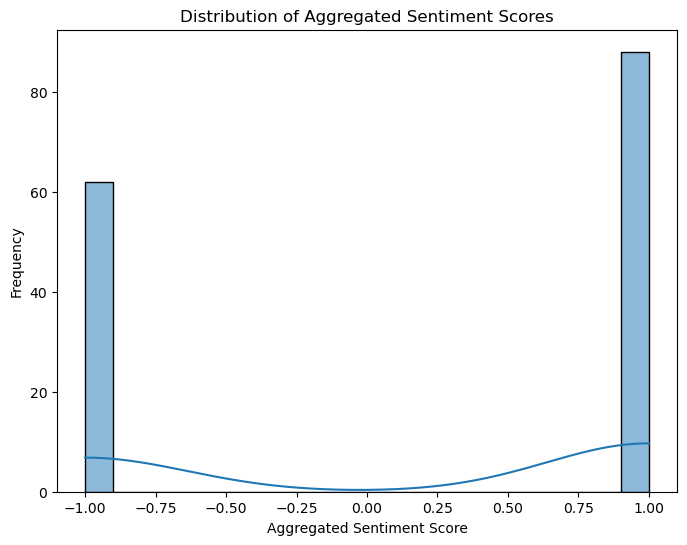

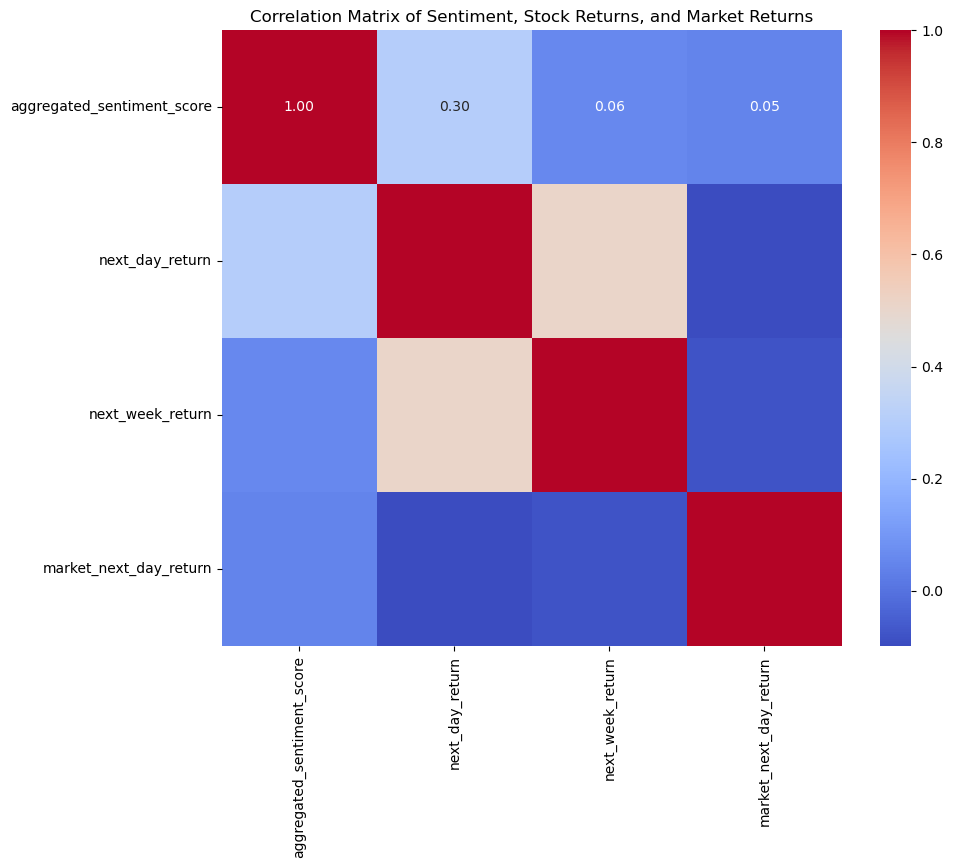

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(merged_df["aggregated_sentiment_score"].dropna(), bins=20, kde=True)
plt.title("Distribution of Aggregated Sentiment Scores")
plt.xlabel("Aggregated Sentiment Score")
plt.ylabel("Frequency")
plt.show()

correlation_data = merged_df[["aggregated_sentiment_score", "next_day_return", "next_week_return", "market_next_day_return"]].dropna()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Sentiment, Stock Returns, and Market Returns")
plt.show()
